# Demo of Model pipeline
1. Find images with similar global descriptors
2. Cluster by covisiblity
3. Find local descriptors
4. Match to SfM model
5. Calculate pose

## Setup: Imports, Loading data
Loading data into memory. This may take some minutes.

In [2]:
import os
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torchvision import transforms
import cv2
import time
from collections import namedtuple
import sqlite3
#import read_model as rm
import nearpy
import threading
from pyquaternion import Quaternion
import transforms3d.quaternions as txq
import matplotlib.colors as mcolors

from dataset_loaders.txt_to_db import get_images, get_points
from dataset_loaders.utils import load_image
from dataset_loaders.pose_utils import quaternion_angular_error
import models.netvlad_vd16_pitts30k_conv5_3_max_dag as netvlad
import models.demo_superpoint as superpoint

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def rotmat2qvec(R):
    Rxx, Ryx, Rzx, Rxy, Ryy, Rzy, Rxz, Ryz, Rzz = R.flat
    K = np.array([
        [Rxx - Ryy - Rzz, 0, 0, 0],
        [Ryx + Rxy, Ryy - Rxx - Rzz, 0, 0],
        [Rzx + Rxz, Rzy + Ryz, Rzz - Rxx - Ryy, 0],
        [Ryz - Rzy, Rzx - Rxz, Rxy - Ryx, Rxx + Ryy + Rzz]]) / 3.0
    eigvals, eigvecs = np.linalg.eigh(K)
    qvec = eigvecs[[3, 0, 1, 2], np.argmax(eigvals)]
    if qvec[0] < 0:
        qvec *= -1
    return qvec

def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
        1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

def colmap_image_to_pose(image):
    im_T_w = np.eye(4)
    im_T_w[:3, :3] = qvec2rotmat(image.qvec)
    im_T_w[:3, 3] = image.tvec
    w_T_im = np.linalg.inv(im_T_w)
    return w_T_im


In [4]:
def get_cursor(name):
    return sqlite3.connect(name).cursor()

def descriptors_from_colmap_db(cursor, image_id):
    #print('Select descriptors from image_id=%d'%image_id)
    cursor.execute('SELECT cols, data FROM descriptors WHERE image_id=?;',(image_id,))
    feature_dim, blob = next(cursor)
    desc = np.frombuffer(blob, dtype=np.uint8).reshape(-1, feature_dim)
    return desc


def keypoints_from_colmap_db(cursor, image_id):
    cursor.execute('SELECT cols, data FROM keypoints WHERE image_id=?;',(image_id,))
    cols, blob = next(cursor)
    kpts = np.frombuffer(blob, dtype=np.float32).reshape(-1, cols)
    return kpts

def get_kpts_desc(cursor, image_id):
    image_id = int(image_id)
    kpts = keypoints_from_colmap_db(cursor, image_id)[:, :2]
    desc = descriptors_from_colmap_db(cursor, image_id)
    return kpts, desc

def get_img_id(cursor, img_name):
    img_id, = next(cursor.execute('SELECT image_id FROM images WHERE name="%s";'%img_name))
    return img_id

def get_img_id_dataset(cursor, dataset_id):
    db_query_name = 'db/%d.jpg'%dataset.get_img_id(dataset_id)
    return get_img_id(cursor, db_query_name)

def kpts_to_cv(kpts, kpt_size=1.0):
    cv_kpts = []
    for i, kpt in enumerate(kpts):
        cv_kpts.append(cv2.KeyPoint(x=kpt[0], y=kpt[1], _size=kpt_size))
    return cv_kpts


In [5]:
t = time.time()
images = get_images()
points3d = get_points()
t = time.time() - t
print('Loaded data in {:.2f} seconds'.format(t))

Loaded data in 62.31 seconds


In [6]:
get_img = lambda i: np.array(load_image('data/AachenDayNight/images_upright/{}'.format(images[i].name)))

In [7]:
database_cursor = get_cursor('data/AachenDayNight/aachen.db')
query_cursor = get_cursor('data/queries.db')

kpt_size = 1.

In [8]:
def percentage_stats(errors_trans, errors_rot):
    num_high, num_medium, num_coarse = 0,0,0
    for t, q in zip(errors_trans, errors_rot):
        if t <= 0.5 and q <= 2.0:
            num_high += 1
        if t <= 1.0 and q <= 5.0:
            num_medium += 1
        if t <= 5.0 and q <= 10.0:
            num_coarse += 1
    per_high = float(num_high)/float(len(errors_trans))*100.0
    per_medium = float(num_medium)/float(len(errors_trans))*100.0
    per_coarse = float(num_coarse)/float(len(errors_trans))*100.0
    return (per_high, per_medium, per_coarse)

print('Percentage results\t{:.1f} / {:.1f} / {:.1f}\n'.format(*percentage_stats([0.1, .9, 4.5, 11.0],[1.0, 2.5, 5.5, 11.0])), end='')

Percentage results	25.0 / 50.0 / 75.0


In [9]:
##create image clusters
t = time.time()
img_cluster = {img : set() for img in images.keys()} 
for p_id in points3d.keys(): 
    img_ids = set(points3d[p_id].image_ids)
    for img_id in img_ids:
        #if img_id in img_cluster:
        img_cluster[img_id] |= img_ids
        #else:
        #    img_cluster[img_id] = set(img_ids)
t = time.time() - t
print('Found %d cluster in %d s'%(len(img_cluster), t))

Found 4328 cluster in 30 s


In [10]:
# Camera matrix
camera_matrices = {}
query_intrinsics_files = ['data/AachenDayNight/queries/day_time_queries_with_intrinsics.txt',
                         'data/AachenDayNight/queries/night_time_queries_with_intrinsics.txt',
                         'data/AachenDayNight/database_intrinsics.txt'
                         ]
for file_path in query_intrinsics_files:
    with open(file_path, 'r') as f:
        lines = [l.strip() for l in f.readlines()]
        for line in lines:
            # Format: `image_name SIMPLE_RADIAL w h f cx cy r`
            line = line.split(' ')
            img_path = line[0]
            f = float(line[4])
            cx = float(line[5])
            cy = float(line[6])
            rad_dist = float(line[7])
            A = np.array([[f, 0, cx],[0, f, cy], [0, 0, 1]])
            camera_matrices[img_path] = {'cameraMatrix': A, 'rad_dist':rad_dist}

In [11]:
global_resolution = 256
n_images = 2

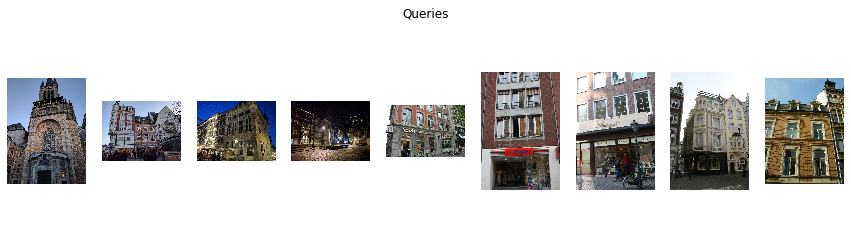

In [12]:
"""
2 day time queries
2 night time queries
2 dataset queries
"""
dataset_queries = [1, 500, 250, 2500, 4000]
path_to_queries = [
                   'data/AachenDayNight/images_upright/query/day/nexus5x/IMG_20161227_162905.jpg',
                   'data/AachenDayNight/images_upright/query/day/nexus5x/IMG_20161227_160713.jpg',
                   'data/AachenDayNight/images_upright/query/night/nexus5x/IMG_20161227_172616.jpg',
                   'data/AachenDayNight/images_upright/query/night/nexus5x/IMG_20161227_191152.jpg',
                   #'data/AachenDayNight/images_upright/db/1.jpg',
                   #'data/AachenDayNight/images_upright/db/500.jpg'
                  ] + ['data/AachenDayNight/images_upright/db/'+str(i)+'.jpg' for i in dataset_queries]
n_queries = len(path_to_queries)
low_res_transform = transforms.Compose([transforms.Resize(global_resolution), transforms.CenterCrop(global_resolution)])
query_imgs_high_res = [load_image(path) for path in path_to_queries]
#query_imgs_low_res = [transform(img) for img in query_imgs_high_res]
fig = plt.figure(figsize=(15,4))
plt.title('Queries')
plt.axis('off')
for i, img in enumerate(query_imgs_high_res):
    a = fig.add_subplot(1, len(query_imgs_high_res), i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## 1. Find similar images (global descriptors)

In [13]:
model = netvlad.vd16_pitts30k_conv5_3_max_dag(weights_path='data/teacher_models/netvlad_pytorch/vd16_pitts30k_conv5_3_max_dag.pth')
model.eval()
query_global_desc = [model(transforms.ToTensor()(low_res_transform(img)).unsqueeze(0)).detach().cpu().squeeze(0).numpy() for img in query_imgs_high_res]
query_global_desc = np.vstack(query_global_desc)
print(query_global_desc.shape)

(9, 131072)


Global descriptors for dataset are precalculated

In [14]:
print('Loading database global features')
t = time.time()
global_features_cursor = get_cursor('data/global_features.db')
global_features = []
image_ids = []
for row in global_features_cursor.execute('SELECT image_id, cols, data FROM global_features;'):
    global_features.append(np.frombuffer(row[2], dtype=np.float32).reshape(-1, row[1]))
    image_ids.append(row[0])
global_features = np.vstack(global_features)
print(global_features.shape)
global_features_cursor.close()
t = time.time() - t
print('%d seconds'%t)

Loading database global features
(4328, 131072)
34 seconds


In [15]:
global_neighbor_method = 'exact' #choices=['LSH', 'exact']

In [16]:
t = time.time()
if global_neighbor_method is 'LSH':
    buckets = 4
    engine = nearpy.Engine(global_features.shape[1], lshashes=[nearpy.hashes.RandomBinaryProjections('rbp', buckets)],
                          distance = nearpy.distances.EuclideanDistance())
    counts = []
    for i, v in enumerate(global_features):
        engine.store_vector(v, '%d'%i)
        counts.append(engine.candidate_count(v))
    indices = [engine.neighbours(d) for d in query_global_desc]
    indices = np.array([np.array([int(n[1]) for n in nbr])[:n_images] for nbr in indices])
    counts = np.array(counts)
    print('Candidate count max: {}\nCandidate count min: {}\nCandidate count avg: {}\nCandidate count median: {}'.format(counts.max(), counts.min(), counts.mean(), np.median(counts)))
    print('Optimal: {}'.format(global_features.shape[1]/float(2**buckets)))
elif global_neighbor_method is 'exact':
    print('Find nearest neighbors for queries')
    print('%d data points with %d sized feature vectors'%(global_features.shape[0], global_features.shape[1]))
    nbrs = NearestNeighbors(n_neighbors=n_images).fit(global_features)
    print('Fitted')
    distances, indices = nbrs.kneighbors(query_global_desc)
    global_features_cursor.close()
t = time.time() - t
print('%d seconds'%t)

Find nearest neighbors for queries
4328 data points with 131072 sized feature vectors
Fitted
156 seconds


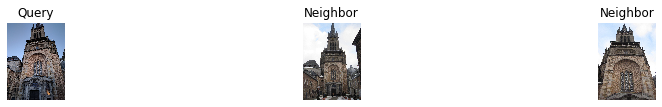

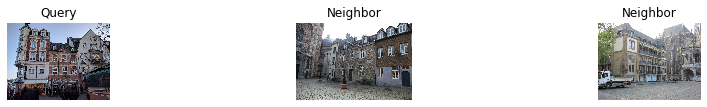

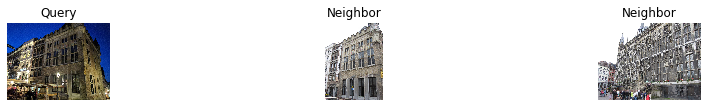

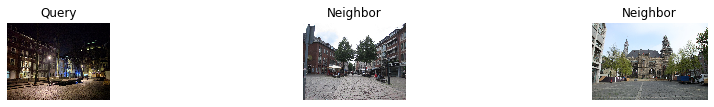

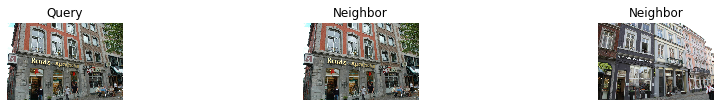

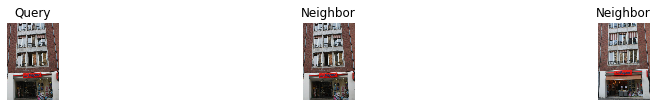

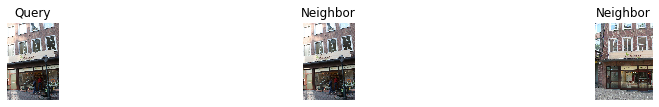

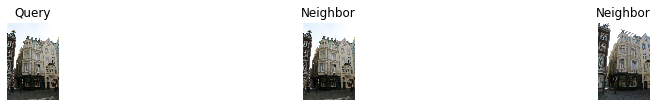

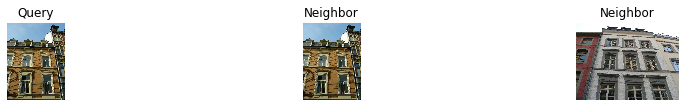

In [17]:
for i, query_img in enumerate(query_imgs_high_res):
    imgs = [query_img] 
    imgs = imgs + [get_img(image_ids[j]) for j in indices[i]]
    fig = plt.figure(figsize=(15,15))
    #plt.title('Neighbors')
    for j, img in enumerate(imgs):
        a = fig.add_subplot(n_queries, n_images+1, i*(n_images+1)+j+1)
        plt.imshow(img)
        if j > 0:
            plt.title('Neighbor')#'%.0f'%distances[i][j-1])
        else:
            plt.title('Query')
        plt.axis('off')
    plt.show()

## 2. Covisibility clustering

In [18]:
query_id = 2

In [19]:
## convert indices to colmap indices
#indices_colmap = np.array([get_img_id_dataset(database_cursor, xii) for xi in indices for xii in xi]).reshape(indices.shape)

In [20]:
cluster_query = [img_cluster[image_ids[indices[query_id][0]]]]
cluster_orig_ids = [image_ids[indices[query_id][0]]]
for i, ind in enumerate(indices[query_id]):
    ind = image_ids[ind]
    if i == 0:
        continue
    point_set = img_cluster[ind]
    print('Match neighbor %d'%i)
    disjoint = False
    for j, c in enumerate(cluster_query):
        if ind in c:
            print('  - Can be matched to cluster')
            #print(point_set - (point_set-cluster))
            cluster_query[j] |= point_set
            disjoint = True
            break
    if not disjoint:
        print('  - New cluster created')
        cluster_orig_ids.append(ind)
        cluster_query.append(point_set)

Match neighbor 1
  - New cluster created


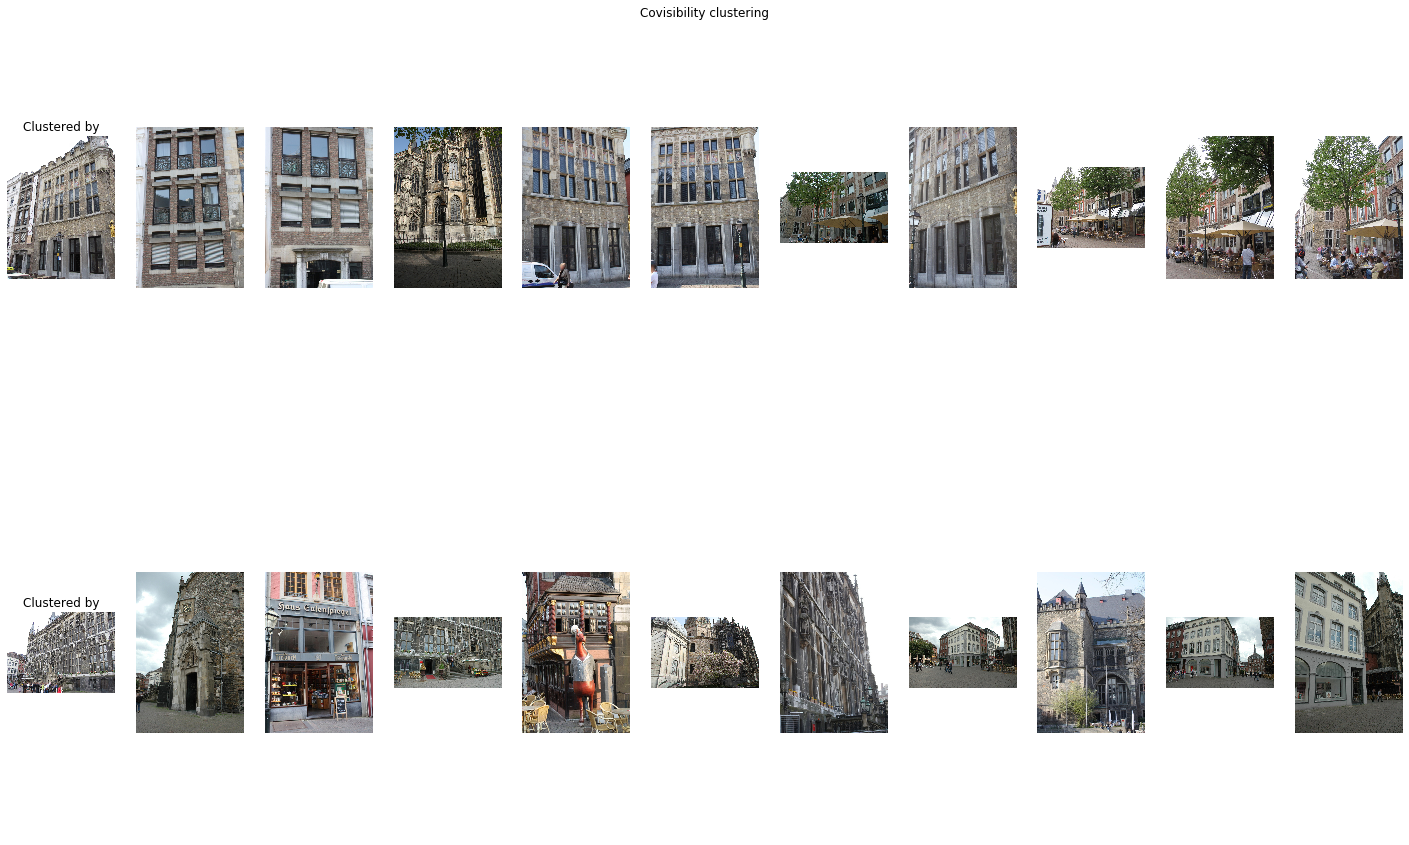

In [21]:
num_imgs_per_cluster = 10
fig = plt.figure(figsize=(25,15))
plt.title('Covisibility clustering')
plt.axis('off')
for i, cluster in enumerate(cluster_query):
    imgs = list(cluster_query[i])[:num_imgs_per_cluster]
    imgs = [get_img(cluster_orig_ids[i])]+[get_img(j) for j in imgs]
    for j, img in enumerate(imgs):
        a = fig.add_subplot(len(cluster_query), len(imgs), i*len(imgs)+j+1)
        plt.imshow(img)
        plt.axis('off')
        if j == 0:
            plt.title('Clustered by')
plt.show()

In [22]:
cluster_points = []
for i, c in enumerate(cluster_query):
    imgs_cluster = list(c)
    points_cluster = set()
    for ind in imgs_cluster:
        pt_ids = images[ind].point3D_ids
        valid = pt_ids > 0
        points_cluster |= set(pt_ids[valid])
    points_cluster = list(points_cluster)
    cluster_points.append(np.stack([points3d[x].xyz for x in points_cluster]))
    """mask = np.ones(len(points3d),dtype=bool) #np.ones_like(a,dtype=bool)
    mask[points_cluster] = False

    cluster_points.append(points3d[~mask])"""
    print('%d\tpoints in cluster'%cluster_points[i].shape[0])
#other_points = points[mask]
#print('%d other points'%other_points.shape[0])

95912	points in cluster
200330	points in cluster


Median is [ 727.28723422    4.2807523  -163.67494432]


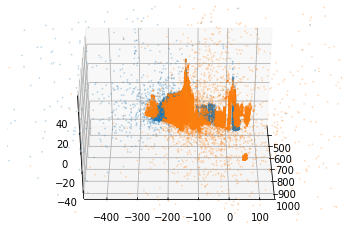

In [23]:
thresh = 300
ax = plt.axes(projection='3d')
#ax.scatter3D(other_points[:,0], other_points[:,2], other_points[:,1], s = 0.5, alpha = 0.01)
for cp in cluster_points:
    ax.scatter3D(cp[:,0], cp[:,2], cp[:,1], s = 0.5, alpha = 0.25)
median = np.sum([np.median(cp, axis=0)*cp.shape[0] for cp in cluster_points], axis=0)/float(sum([cp.shape[0] for cp in cluster_points]))
print('Median is %s'%median)
ax.set_xlim3d(median[0]-thresh,median[0]+thresh)#min(sift_points[:,0]),min(sift_points[:,0])+max_dist)
ax.set_ylim3d(median[2]-thresh,median[2]+thresh)#min(sift_points[:,1]),min(sift_points[:,1])+max_dist)
ax.set_zlim3d(median[1]-50, median[1]+50)#min(sift_points[:,2]),min(sift_points[:,2])+max_dist)
ax.view_init(elev=35., azim=0)
plt.show()

## 3. Find local descriptors

In [24]:
test_id = cluster_orig_ids[0] #197

<b> Order to get image - keypoint - 3D point correspondances: </b>
1. take image
2. find image name
3. find db_id of image_name
4. get keypoints
5. get valid 3d points

night/nexus5x/IMG_20161227_172616.jpg


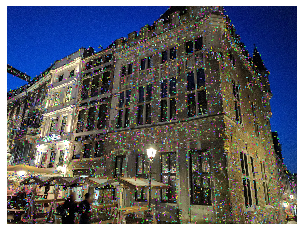

In [25]:
if query_id < 4:
    test_query_path = path_to_queries[query_id].replace('data/AachenDayNight/images_upright/query/', '')
    print(test_query_path)
    query_img_id = get_img_id(query_cursor, test_query_path)
    query_kpts, query_desc = get_kpts_desc(query_cursor, query_img_id)
else:
    fake_query_path = 'db/'+path_to_queries[query_id].split('/')[-1]
    query_kpts, query_desc = get_kpts_desc(database_cursor, get_img_id(database_cursor,fake_query_path))
    
query_kpts = kpts_to_cv(query_kpts)
query_img = cv2.drawKeypoints(np.array(query_imgs_high_res[query_id]),query_kpts, None)
plt.imshow(query_img)
plt.axis('off')
plt.show()

db/1254.jpg
len kpts: 4763


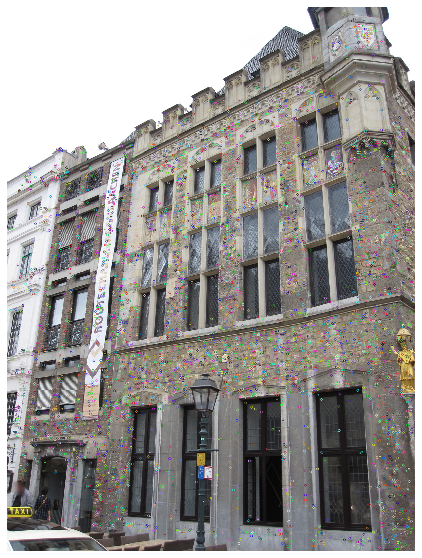

(4763,)
4763
11127
(4763, 128)


In [26]:
test_id = cluster_orig_ids[0]
db_id = test_id#get_img_id_dataset(database_cursor, test_id)
img_name = images[db_id].name
neighbor_img_original = np.array(load_image('data/AachenDayNight/images_upright/'+img_name))
print(img_name)
valid = images[db_id].point3D_ids > 0 
#print([i for i in range(len(valid)) if valid[i]])
neighbor_kpts, neighbor_desc = get_kpts_desc(database_cursor, db_id)
neighbor_kpts = neighbor_kpts[valid[:neighbor_kpts.shape[0]]] - 0.5
neighbor_kpts_cv = kpts_to_cv(neighbor_kpts)
pt_ids = images[db_id].point3D_ids[valid]
print('len kpts: %d'%len(neighbor_kpts_cv))
plt.figure(figsize=(10,10))
neighbor_img = cv2.drawKeypoints(neighbor_img_original,neighbor_kpts_cv, None)
plt.imshow(neighbor_img)
plt.axis('off')
plt.show()
neighbor_desc = neighbor_desc[valid[:neighbor_desc.shape[0]]]
#print(images[db_id])
print(pt_ids.shape)
print(len(neighbor_kpts_cv))
print(len(valid)//2)
print(neighbor_desc.shape)

In [27]:
extractor = superpoint.SuperPointFrontend(weights_path='data/teacher_models/superpoint_v1.pth',
                          nms_dist=4, conf_thresh=0.015, nn_thresh=.7, cuda=torch.cuda.is_available())

In [28]:
def rgb2gray(rgb):
    rgb = np.dot(rgb[...,:3], [0.299, 0.587, 0.144]).astype(np.float32) 
    return rgb / rgb.max()
example_grayscale = rgb2gray(np.array(query_imgs_high_res[query_id]))
print(example_grayscale.shape)
print(example_grayscale.dtype)
print(example_grayscale.max())

(1200, 1600)
float32
1.0


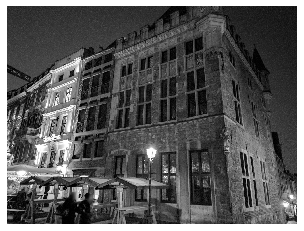

In [29]:
plt.imshow(example_grayscale, cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [58]:
#torch.cuda.empty_cache()  
pts, query_desc, heatmap = extractor.run(example_grayscale)
query_desc = query_desc.T

(3, 3254)
(3254, 256)
(1200, 1600)


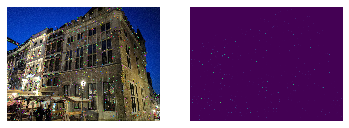

In [59]:
print(pts.shape)  #3xN numpy array with corners [x_i, y_i, confidence_i]^T
print(query_desc.shape) #256xN numpy array of corresponding unit normalized descriptors.
print(heatmap.shape)
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
query_kpts = kpts_to_cv(pts.T)
query_img = cv2.drawKeypoints(np.array(query_imgs_high_res[query_id]),query_kpts, None)
plt.imshow(query_img)
plt.axis('off')
a = fig.add_subplot(1, 2, 2)
plt.imshow(heatmap)
plt.axis('off')
plt.show()

In [33]:
neighbor_img_original_gs = rgb2gray(neighbor_img_original)
_, neighbor_desc, heatmap = extractor.run(neighbor_img_original_gs, points=neighbor_kpts)
neighbor_desc = neighbor_desc.T

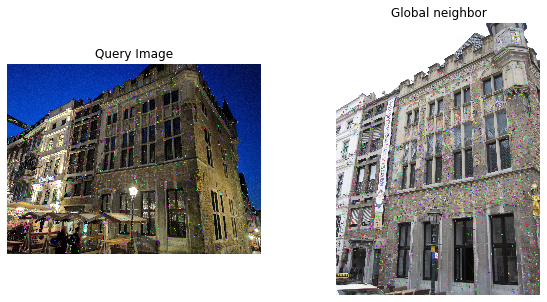

In [34]:
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(query_img)
plt.axis('off')
plt.title('Query Image')
a = fig.add_subplot(1,2,2)
plt.imshow(neighbor_img)
plt.axis('off')
plt.title('Global neighbor')
plt.show()

In [35]:
def _thread_match(query, data, out_field, i):
    out_field[i] = np.sum([np.square(data - q) for q in query], axis=2)

def own_matching_threading(query, data, ratio=.75, num_threads=12):
    piece = query.shape[0]//num_threads
    results = [None] * num_threads
    ts = [*[threading.Thread(target=_thread_match, args=(query[i*piece:(i+1)*piece,:],data,results, i)) for i in range(num_threads-1)], threading.Thread(target=_thread_match, args=(query[piece*(num_threads-1):,:],data,results, num_threads-1))]
    for thread in ts:
        thread.start()
    for thread in ts:
        thread.join()
    #print(results[0].shape)
    dist = np.concatenate(results)
    #print(dist.shape)
    
    matches = np.argsort(dist)[:,:2]
    good_matches = []
    for i, (a, b) in enumerate(matches): ## i: query index | a,b: data indices
        if dist[i,b] > ratio*dist[i, a]:
            good_matches.append([i,a])
    return good_matches

#test = [None]
#_thread_match(query_desc[:20,:], neighbor_desc, test, 0)
#print(test[0].shape)
print('Creating test arrays')
m = 1000
n = 500
d = 128
test_q = np.random.randint(0, 255, size=(m, d), dtype=np.uint8)
test_d = np.random.randint(0, 255, size=(n, d), dtype=np.uint8)
t = time.time()
matches = own_matching_threading(test_q, test_d)
t = time.time() - t
print('Threading took {:.2f} seconds'.format(t))
#t = time.time()
#matches = own_matching(test_q, test_d)
#t = time.time() - t
#print('Normal took {:.2f} seconds'.format(t))
t = time.time()
matcher = cv2.BFMatcher.create(cv2.NORM_L2)
matches = matcher.knnMatch(test_d, test_q, k=2)
good = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
t = time.time() - t
print('BF took {:.2f} seconds'.format(t))
del matches, test_q, test_d

Creating test arrays
Threading took 0.25 seconds
BF took 0.02 seconds


In [36]:
def __bf_matching__(x, y, ratio_thresh=0.75):
    matcher = cv2.BFMatcher.create(cv2.NORM_L2)
    matches = matcher.knnMatch(x, y, k=2)
    good = []
    for i,(m,n) in enumerate(matches):
        if m.distance < ratio_thresh*n.distance:
            good.append(m)
    matches = np.array([[g.trainIdx, g.queryIdx] for g in good])
    return matches



In [37]:
def __approx_np__(x,y, ratio_thresh=.5):
    ##normalize
    #t = time.time()
    x = x.astype(np.float32)/np.linalg.norm(x.astype(np.float32),axis=-1, keepdims=True)
    y = y.astype(np.float32)/np.linalg.norm(y.astype(np.float32),axis=-1, keepdims=True)
    #t = time.time() - t
    #print('Normalization takes {:.2f} s'.format(t))
    #t = time.time()
    d = 1.-np.matmul(y, x.T)
    k = np.argpartition(d, 2, axis=1)[:,:2]
    #intm = np.argsort(np.array([d[i, ap[i]] for i in range(ap.shape[0])]), axis=1)
    #k = np.array([ap[i,a] for i, a in enumerate(intm)])
    #t = time.time() - t
    #print('Actual calculations take {:.2f} s'.format(t))
    #t = time.time()
    #matches = np.array([[i, k[i,0]] for i in range(d.shape[0]) if d[i, k[i, 0]] < (ratio_thresh**2)*d[i,k[i,1]]])
    #t = time.time() - t
    #print('Matching takes {:.2f} s'.format(t))
    #print(d.shape)
    #print(k.shape)
    #print(matches.shape)
    matches = []
    for i, (m, n) in enumerate(k):
        if d[i,m] < d[i,n]: 
            if d[i, m] < ratio_thresh*d[i, n]:
                matches.append([i, m])
        else:
            if d[i, n] < ratio_thresh*d[i, m]:
                matches.append([i, n])
    return np.array(matches)
    
    
t = time.time()
#matches = __approx_np__(neighbor_desc, query_desc, ratio_thresh=.75)
matches = __approx_np__(query_desc, neighbor_desc, ratio_thresh=.75)
t = time.time() - t
print('Took {:.2f} seconds'.format(t))
print(matches.shape)

Took 0.60 seconds
(415, 2)


In [38]:
def __to_unit_torch__(x, cuda):
    if cuda:
        x = torch.from_numpy(x).float().cuda()
    else:
        x = torch.from_numpy(x).float()
    return (x.transpose(0, 1) / torch.norm(x, p=2, dim=1)).transpose(0,1)


def __approx_torch__(x,y,ratio_thresh=.75):
    cuda = torch.cuda.is_available()
    x = __to_unit_torch__(x, cuda=cuda)
    y = __to_unit_torch__(y, cuda=cuda)
    with torch.no_grad():
        d = 1. - torch.matmul(x, y.transpose(0,1))
        values, indices = torch.topk(d, 2, dim=1, largest=False, sorted=True)
        valid = values[:,0] < ratio_thresh**2*values[:,1]
        if not torch.any(valid):
            return np.array([])
        indices_valid = indices[valid][:,0]
        if cuda:
            valid_indices = torch.arange(valid.size()[0]).cuda()[valid]
        else:
            valid_indices = torch.arange(valid.size()[0])[valid]
        ret = torch.stack([torch.Tensor([valid_indices[i], indices_valid[i]]) for i in range(valid_indices.shape[0])])
        return ret.cpu().numpy().astype(np.int64) if cuda else ret.numpy().astype(np.int64)
    """matches = []
    for j, (v,i) in enumerate(zip(values, indices)):
        if v[0] < ratio_thresh*v[1]:
            matches.append([j, i[0]])
    return np.array(matches)
    """
    
t = time.time()
matches = __approx_torch__(neighbor_desc, query_desc, ratio_thresh=.75)
t = time.time() - t
print(matches.shape)
print(matches.dtype)
print('Took {:.2f} seconds'.format(t))


(101, 2)
int64
Took 0.37 seconds


In [39]:
matching_type = 'torch_approx' # choices = ['Flann', 'BF', 'own']


t = time.time()
print(query_desc.shape)
print(neighbor_desc.shape)
if matching_type == 'BF':
    matches = __bf_matching__(neighbor_desc, query_desc)
elif matching_type == 'approx':
    matches = __approx_np__(neighbor_desc, query_desc)
elif matching_type == 'torch_approx':
    matches = __approx_torch__(query_desc, neighbor_desc)
elif matching_type == 'own':
    matches = own_matching(neighbor_desc, query_desc)
elif matching_type == 'own_threading':
    matches = own_matching_threading(neighbor_desc, query_desc)
elif matching_type == 'pytorch':
    matches = own_matching_pytorch(neighbor_desc, query_desc)
elif matching_type == 'LSH':
    matches = LSH_matching(neighbor_desc, query_desc)
elif matching_type == 'fast':
    q = query_desc.astype(np.float32)   / np.linalg.norm(query_desc.astype(np.float32),    axis=-1, keepdims=True)
    n = neighbor_desc.astype(np.float32)/ np.linalg.norm(neighbor_desc.astype(np.float32), axis=-1, keepdims=True)
    matches = fast_matching(n, q, ratio_thresh=.75)
else:
    raise NotImplementedError('Not Implemented')
print(matches.shape)
matches = [cv2.DMatch(_queryIdx=m[1], _trainIdx=m[0], _imgIdx=0, _distance=1.0) for m in matches]
t = time.time() - t
print('Matching took {:.1f} seconds\nFound {} matches'.format(t, len(matches)))

(3254, 256)
(4763, 256)
(30, 2)
Matching took 0.0 seconds
Found 30 matches


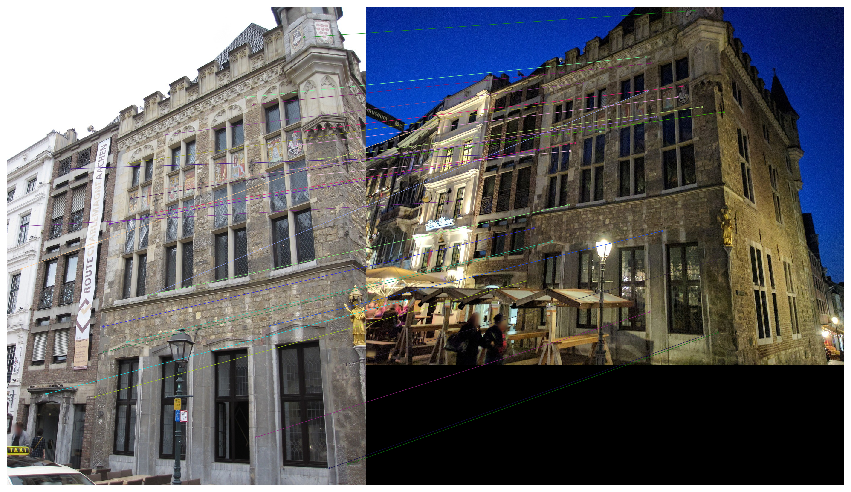

In [40]:
# cv2.drawMatchesKnn expects list of lists as matches.
#draw_params = dict(matchColor = (0,255,0),
#                   singlePointColor = (255,0,0),
#                   matchesMask = matchesMask,
#                   flags = 2)
img3 = np.empty((max(query_img.shape[0], neighbor_img.shape[0]), query_img.shape[1] + neighbor_img.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(neighbor_img_original,neighbor_kpts_cv,np.array(query_imgs_high_res[query_id]),query_kpts,matches,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
plt.figure(figsize=(15,15))
plt.imshow(img3)
plt.axis('off')
plt.show()

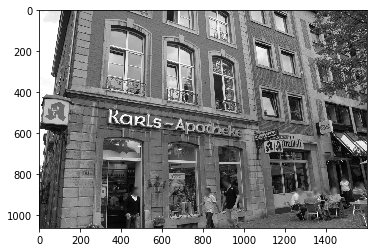

(1063, 1600)


In [41]:
img_name = images[1].name
cv_img = cv2.imread('data/AachenDayNight/images_upright/'+img_name, 0).astype(np.float32)/255.0
plt.imshow(cv_img, cmap = plt.get_cmap('gray'))
plt.show()
print(cv_img.shape)

(3254, 256)


In [62]:
##settings
ratio_thresh = 0.75# 0.75
matching_type = 'torch_approx'
extraction = 'superpoint'


t = time.time()
matched_kpts_cv = []
matched_pts = []
superpoint_cursor = sqlite3.connect('data/superpoint.db').cursor()
print('Start')
for c in cluster_query:
    for img in c:
        db_id = img # get_img_id_dataset(database_cursor, img)
        valid = images[db_id].point3D_ids > 0 
        pt_ids = images[db_id].point3D_ids[valid]
        if extraction == 'colmap':
            data_kpts, data_desc = get_kpts_desc(database_cursor, db_id)
            #data_kpts_cv = kpts_to_cv(data_kpts[valid[:data_kpts.shape[0]]] - 0.5)
            data_desc = data_desc[valid[:data_desc.shape[0]]]
        if extraction == 'superpoint':
            superpoint_cursor.execute('SELECT cols, desc FROM local_features WHERE image_id==?;',(int(db_id),))
            cols, desc = next(superpoint_cursor)
            data_desc = np.frombuffer(desc, dtype=np.float32).reshape(cols, 256)
            #except:
            #    print(db_id)
            #    continue
                
            

        if matching_type == 'BF':
            matches = __bf_matching__(query_desc, data_desc)
        elif matching_type == 'approx':
            matches = __approx_np__(query_desc, data_desc)
        elif matching_type == 'torch_approx':
            matches = __approx_torch__(data_desc, query_desc)
        elif matching_type == 'own':
            matches = own_matching(query_desc, data_desc)
        elif matching_type == 'own_threading':
            matches = own_matching_threading(query_desc, data_desc, num_threads=8)
        elif matching_type == 'pytorch':
            matches = own_matching_pytorch(query_desc, data_desc)
        elif matching_type == 'LSH':
            matches = LSH_matching(query_desc, data_desc, buckets = 10)
        elif matching_type == 'fast':
            q = query_desc.astype(np.float32)/ np.linalg.norm(query_desc.astype(np.float32),    axis=-1, keepdims=True)
            n = data_desc.astype(np.float32)/ np.linalg.norm(data_desc.astype(np.float32), axis=-1, keepdims=True)
            matches = fast_matching(q, n, ratio_thresh=ratio_thresh)
            
        matched_kpts_cv += [query_kpts[m[1]] for m in matches]
        matched_pts += [pt_ids[m[0]] for m in matches]
        

t = time.time() - t
superpoint_cursor.close()
print('Total matching time: {:.2f} seconds'.format(t))

Start
Total matching time: 672.76 seconds


In [92]:
matched_pts_xyz = np.stack([points3d[i].xyz for i in matched_pts])
print(matched_pts_xyz.mean(axis=0))
print(matched_pts_xyz.shape)

[709.61456276   2.91869528   7.84391994]
(34306, 3)


In [93]:
matched_keypoints = np.vstack([np.array([x.pt[0], x.pt[1]]) for x in matched_kpts_cv])
print(matched_keypoints.shape)

(34306, 2)


## 5. Calculate pose

In [94]:
query_path = path_to_queries[query_id].replace('data/AachenDayNight/images_upright/', '')
cm = camera_matrices[query_path]
camera_matrix = cm['cameraMatrix']
distortion_coeff = cm['rad_dist']
print(camera_matrix)
print(distortion_coeff)

[[1.1958e+03 0.0000e+00 6.0000e+02]
 [0.0000e+00 1.1958e+03 8.0000e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00]]
0.0142778


In [95]:
n_iter = 1000

In [96]:
t = time.time()
dist_vec = np.array([distortion_coeff, 0, 0, 0])
success, R_vec, translation, inliers = cv2.solvePnPRansac(
        matched_pts_xyz, matched_keypoints, camera_matrix, dist_vec,
        iterationsCount=n_iter, reprojectionError=10.,
        flags=cv2.SOLVEPNP_P3P)
t = time.time() - t
print('PnP RANSAC took %d seconds (%.2f/iteration)'%(t, float(t)/float(n_iter)))

PnP RANSAC took 0 seconds (0.00/iteration)


In [97]:
if success:
    print('Successful matching')
    print(inliers.shape)
else:
    print('Not succesful')
print(R_vec)
print(translation)


Successful matching
(29202, 1)
[[2.05465963]
 [0.50843264]
 [1.66940508]]
[[-152.44205523]
 [-377.46859704]
 [-556.95119911]]


In [98]:
print(matched_pts_xyz[inliers].shape)
print(matched_keypoints[inliers].shape)

(29202, 1, 3)
(29202, 1, 2)


In [99]:
min_inliers = 10

if success:
    inliers = inliers[:, 0] if len(inliers.shape) > 1 else inliers
    num_inliers = len(inliers)
    inlier_ratio = len(inliers) / len(matched_keypoints)
    success &= num_inliers >= min_inliers

    ret, R_vec, t = cv2.solvePnP(
                matched_pts_xyz[inliers], matched_keypoints[inliers], camera_matrix,
                dist_vec, rvec=R_vec, tvec=translation, useExtrinsicGuess=True,
                flags=cv2.SOLVEPNP_ITERATIVE)
    assert ret

    query_T_w = np.eye(4)
    query_T_w[:3, :3] = cv2.Rodrigues(R_vec)[0]
    query_T_w[:3, 3] = t[:, 0]
    w_T_query = np.linalg.inv(query_T_w)

    #ret = LocResult(success, num_inliers, inlier_ratio, w_T_query)

In [100]:
print(w_T_query)

[[ 2.04673620e-01  5.39675530e-01  8.16614371e-01  6.89710401e+02]
 [ 6.93816278e-03 -8.35054679e-01  5.50123208e-01 -7.23169262e+00]
 [ 9.78805686e-01 -1.06929905e-01 -1.74658021e-01  1.29215191e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [101]:
#print(w_T_query)
qvec_nvm = list(Quaternion(matrix=query_T_w)) # rotmat2qvec(w_T_query[:3,:3])
pos = -txq.rotate_vector(w_T_query[:3,3], qvec_nvm)
print('Calculated position: {}\nOrientation: {}'.format(w_T_query[:3, 3], qvec_nvm))
print('Transformed position: {}'.format(pos))
if query_id > 3:
    #pose_stats_filename = os.path.join('data/AachenDayNight/', 'pose_stats.txt')
    #mean_t, std_t = np.loadtxt(pose_stats_filename)
    #position = dataset[dataset_queries[query_id-4]][1][:3]
    #position = position*std_t + mean_t
    position = colmap_image_to_pose(images[get_img_id(database_cursor, fake_query_path)])[:3,3]
    rotation = images[get_img_id(database_cursor, fake_query_path)].qvec
    
    #query_T_w = np.linalg.inv(result.T)
    #pos_nvm = query_T_w[:3, 3].tolist()
    
    error_rot = quaternion_angular_error(rotation, qvec_nvm)
    error = np.linalg.norm(position-w_T_query[:3,3])
    error_str = '%.1f m'%error if error > 1e-1 else '%.1f cm'%(100.0*error)
    print('Groundtruth: \t%s \nError transl.: \t%s\nAngular error: \t%.2f°'%(str(position), error_str, error_rot))


Calculated position: [689.71040096  -7.23169262  12.92151914]
Orientation: [0.22077189579740683, 0.74404071132306, 0.18366390597367904, 0.6032667399769238]
Transformed position: [-153.76300638 -376.87698826 -556.99225651]


In [104]:
if query_id == 2:
    qvec_mapnet = np.array([0.14751838147640228, 0.7848054766654968, -0.09522610157728195, -0.5943489670753479])
    pos_mapnet = np.array([-379.47140824838095, 212.66002640437915, 609.4124687897538])
    print('Difference position: {:.2f}m'.format(np.linalg.norm(pos_mapnet - pos)))
    print('Difference orientation: {:.2f}°'.format(quaternion_angular_error(qvec_mapnet, qvec_nvm)))
    print(w_T_query[:3,3])
    print(-txq.rotate_vector(w_T_query[:3,3], qvec_nvm))
    print(-txq.rotate_vector(pos_mapnet, qvec_mapnet))

In [ ]:
def correct_poses(corrupt_file, new_file_name):
    new_file = open(new_file_name, 'w')
    with open(corrupt_file, 'r') as f:
        lines = [l.strip() for l in f.readlines()]
        for l in lines:
            splt = l.split(' ')
            pos = [float(s) for s in splt[-3:]]
            w_T = np.zeros((4,4))
            w_T[3,3] = 1.0
            w_T[:3,3] = pos
            w_T[:3,:3] = qvec2rotmat([float(s) for s in splt[1:5]])
            T_w = np.linalg.inv(w_T.T)
            quat = list(Quaternion(matrix=T_w))
            pos = -txq.rotate_vector(np.array(pos), np.array(quat))
            img_string = '{} {} {} {} {} {} {} {}\n'.format(splt[0], *list(quat), *pos)
            new_file.write(img_string)
    new_file.close()

In [ ]:
correct_poses('aachen_eval_slurm_5.txt', 'submissions/Aachen_eval_conet_corrected.txt')

## old code




In [ ]:
## stop notebook run all
1.0/0.0

In [ ]:
## Now all clusters
t = time.time()
kpts_des = {}
place_lms = []
for c in cluster_query:
    for img in c:
        kpts = []
        point_ids = measurements[img]['point_id']
        place_lms += point_ids
        for i, kpt in enumerate(measurements[img]['kpts']):
            kpts.append(cv2.KeyPoint(kpt[0], kpt[1], _size=med_kpt_size))
        if len(kpts) <= 0:
            continue
        kpts_des[img] = sift.compute(np.array(dataset[img][0]), kpts)
place_lms = np.array(place_lms)
t = time.time() - t
print('Took %d seconds'%t)

In [ ]:
random_id = list(cluster_query[0])[12]
plt.imshow(cv2.drawKeypoints(np.array(dataset[random_id][0]),kpts_des[random_id][0], None))
plt.show()

In [ ]:
print(len(kpts_des))
print(sum([len(c) for c in cluster_query]))
print(place_lms.shape)
print(kpts_des[random_id][1].shape)

In [ ]:
"""
From https://github.com/ethz-asl/hfnet
"""

def matches_cv2np(matches_cv):
    matches_np = np.int32([[m.queryIdx, m.trainIdx] for m in matches_cv])
    distances = np.float32([m.distance for m in matches_cv])
    return matches_np.reshape(-1, 2), distances

query_des = query_des.astype(np.float32, copy=False)
dataset_des = np.concatenate([kpts_des[x][1] for x in kpts_des]).astype(np.float32, copy=False)
#img_match_ids = [x for i in range(len(kpts_des[x][1])) for x in kpts_des]
#print(len(img_match_ids))


print(type(query_des))
print(type(dataset_des))
print(query_des.shape)
print(dataset_des.shape)

matcher = cv2.BFMatcher(cv2.NORM_L2)
m = matcher.knnMatch(dataset_des, query_des, k=2)

matches1, matches2 = list(zip(*m))
(matches1, dist1) = matches_cv2np(matches1)
(matches2, dist2) = matches_cv2np(matches2)
print(matches1.shape)
print(matches2.shape)
print('Done matching: %d matches'%len(m))

In [ ]:
ratio_thresh = 0.70
#print(matches1[:5])
#print(matches2[:5])
#print(matches1[103])

In [ ]:
print(place_lms.shape)
## Index testing cannot work as we do not know which points are in query (problem would be already solved)
#good = (place_lms[matches1[:, 1]] == place_lms[matches2[:, 1]])
good = (dist1/dist2 < ratio_thresh)
matches_good = matches1[good]

In [ ]:
print(good[:10])
print(matches_good[0])
#print(len([g for g in good if not g]))
#print(len(matches))

In [ ]:
cnt = 0
img_shown = 0
for c in cluster_query:
    for img in c:
        kpt = kpts_des[img][0]
        n = len(kpt)
        cnt += n
        print('%d:%d'%(cnt-n,cnt))
        if not np.any(good[cnt-n:cnt]):
            continue
        
        img_shown += 1
        if img_shown > 5:
            break
        #matches_img = [i for x in m[cnt-n:cnt] for i in x if x[0].distance < ratio_thresh*x[1].distance]
        matches_img = [cv2.DMatch()]
        data_img = np.array(dataset[img][0])
        img3 = np.empty((max(query_sift_img.shape[0], data_img.shape[0]), query_sift_img.shape[1] + data_img.shape[1], 3), dtype=np.uint8)
        cv2.drawMatches(data_img,kpt,query_img,query_kpts,matches_img,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
        plt.imshow(img3)
        plt.axis('off')
        plt.show()

In [ ]:
matched_points = np.stack([points[place_lms[i]] for i in matches[:, 0]])
matched_kpts = np.vstack([np.array(query_kpts[i].pt) for i in matches[:, 1]])

In [ ]:
print(matched_points.shape)
print(matched_kpts.shape)

In [ ]:
thresh = 300
ax = plt.axes(projection='3d')
ax.scatter3D(matched_points[:,0], matched_points[:,2], matched_points[:,1], s = 1.5, alpha = 0.5)
#for cp in cluster_points:
#    ax.scatter3D(cp[:,0], cp[:,2], cp[:,1], s = 0.5, alpha = 0.25)
#ax.scatter3D(translation[0], translation[2], translation[1], s=25, alpha=1.0)
median = np.median(points, axis=0)
print('Median is %s'%median)
#ax.set_xlim3d(median[0]-thresh,median[0]+thresh)#min(sift_points[:,0]),min(sift_points[:,0])+max_dist)
#ax.set_ylim3d(median[2]-thresh,median[2]+thresh)#min(sift_points[:,1]),min(sift_points[:,1])+max_dist)
#ax.set_zlim3d(median[1]-50, median[1]+50)#min(sift_points[:,2]),min(sift_points[:,2])+max_dist)
ax.view_init(elev=35., azim=0)
plt.show()